In [1]:
import matplotlib.pyplot as plt
from tinygrad.tensor import Tensor
import numpy as np
import random

Import additional libraries for DQN

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple

/mnt/e/workspace/townhall/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
class ImprovedEnvironment:
    def __init__(self, num_agents, num_tasks, num_features):
        self.num_agents = num_agents
        self.num_tasks = num_tasks
        self.num_features = num_features
        self.agents = [ImprovedAgent(i, num_tasks, num_features)
                       for i in range(num_agents)]
        self.performance = {i: {task: []
                                for task in range(num_tasks)} for i in range(num_agents)}
        self.agent_positions = {i: [] for i in range(num_agents)}
        self.rewards = {i: {task: []
                            for task in range(num_tasks)} for i in range(num_agents)}
    def step(self):
        for agent in self.agents:
            for task in range(self.num_tasks):
                loss, reward = agent.observe(task)
                self.performance[agent.id][task].append(loss)
                self.rewards[agent.id][task].append(reward)
            self.agent_positions[agent.id].append(
                np.random.rand(2))  # Random 2D positions

In [5]:
class ImprovedAgent:
    def __init__(self, id, num_tasks, num_features):
        self.id = id
        self.num_tasks = num_tasks
        self.num_features = num_features
        self.models = [ImprovedLLM(num_features) for _ in range(num_tasks)]

        # DQN-related attributes
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.target_net = DQN(num_features).to(self.device)
        self.policy_net = DQN(num_features).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = ReplayMemory(10000)
        self.previous_loss = [0] * num_tasks  # Initialize with zeros
    def observe(self, task):
        observations = np.random.rand(
            self.num_features)  # Expanded state space
        target = np.sum(observations)
        loss = self.models[task].train(observations, target)

        # Calculate reward based on the difference between current and previous loss
        reward = self.calculate_reward(loss, task)

        # Update DQN
        self.update_dqn(observations, reward, task)
        return loss, reward
    def calculate_reward(self, loss, task):
        # Calculate reward based on the difference between current and previous loss
        reward = self.previous_loss[task] - loss
        self.previous_loss[task] = loss  # Update the previous loss
        return reward
    def update_dqn(self, state, reward, task):
        self.memory.push(state, task, None, reward)  # Pass None for next_state
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(
            lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool)
        if any(non_final_mask):  # Check if at least one non-final state is present
            # Filter out empty tensors from non_final_next_states
            non_final_next_states = torch.stack(
                [s for s, mask in zip(batch.next_state, non_final_mask) if mask])
            state_batch = torch.stack(
                [s for s, mask in zip(batch.state, non_final_mask) if mask])
            action_batch = torch.tensor(
                [a for a, mask in zip(batch.action, non_final_mask) if mask], device=self.device)
            reward_batch = torch.tensor(
                [r for r, mask in zip(batch.reward, non_final_mask) if mask], device=self.device)
            next_state_values = torch.zeros(
                BATCH_SIZE, device=self.device)
            next_state_values[non_final_mask] = self.target_net(
                non_final_next_states).max(1)[0].detach()
            expected_state_action_values = (
                next_state_values * GAMMA) + reward_batch
            q_values = self.policy_net(state_batch).gather(
                1, action_batch.unsqueeze(1))
            loss = F.smooth_l1_loss(
                q_values, expected_state_action_values.unsqueeze(1))
            self.optimizer.zero_grad()
            loss.backward()
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

In [6]:
class ImprovedLLM:
    def __init__(self, num_features):
        self.num_features = num_features
        self.w1 = Tensor(np.random.randn(5, num_features), requires_grad=True)
        self.w2 = Tensor(np.random.randn(5), requires_grad=True)
    def forward(self, x):
        x = Tensor(x).reshape(1, -1)
        x = self.w1.dot(x.transpose()).relu()
        return self.w2.dot(x)
    def train(self, x, y_true):
        y_pred = self.forward(x)
        loss = ((y_pred - Tensor(y_true)) ** 2).sum()
        loss.backward()
        learning_rate = 0.01
        self.w1 = self.w1 - self.w1.grad * learning_rate
        self.w2 = self.w2 - self.w2.grad * learning_rate
        return loss.numpy()

DQN-related constants

In [7]:
BATCH_SIZE = 64
GAMMA = 0.99

Define DQN network

In [8]:
class DQN(nn.Module):
    def __init__(self, input_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

Define replay memory

In [9]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

Create environment with 3 agents, 2 tasks, and an expanded state space with 4 features

In [10]:
env = ImprovedEnvironment(num_agents=3, num_tasks=2, num_features=4)

Assume 50 steps for training

In [11]:
for step in range(50):
    env.step()

Plot agent positions

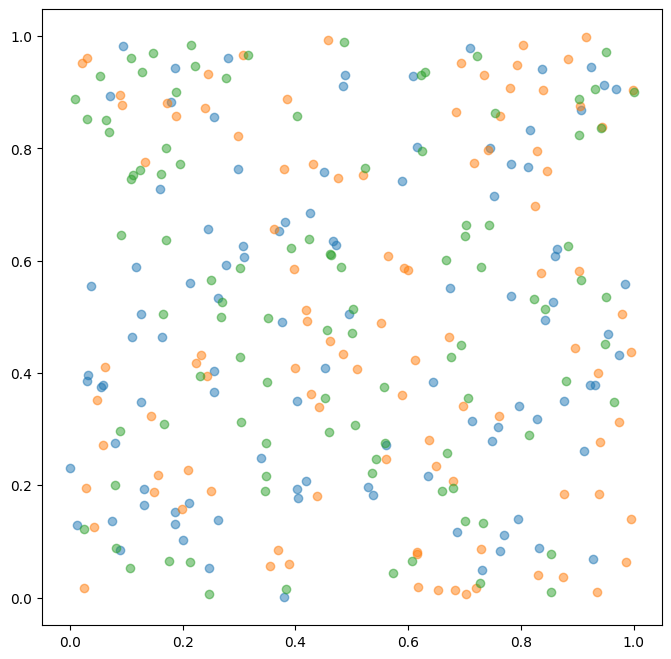

In [ ]:
plt.figure(figsize=(8, 8))
for agent_id, positions in env.agent_positions.items():
    positions = np.array(positions)
    plt.scatter(positions[:, 0], positions[:, 1],
                label=f'Agent {agent_id}', alpha=0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


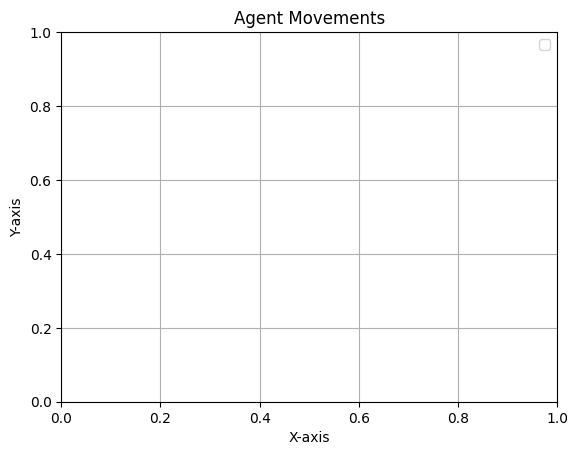

In [ ]:
plt.legend()
plt.title('Agent Movements')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

Plot performance for task 0

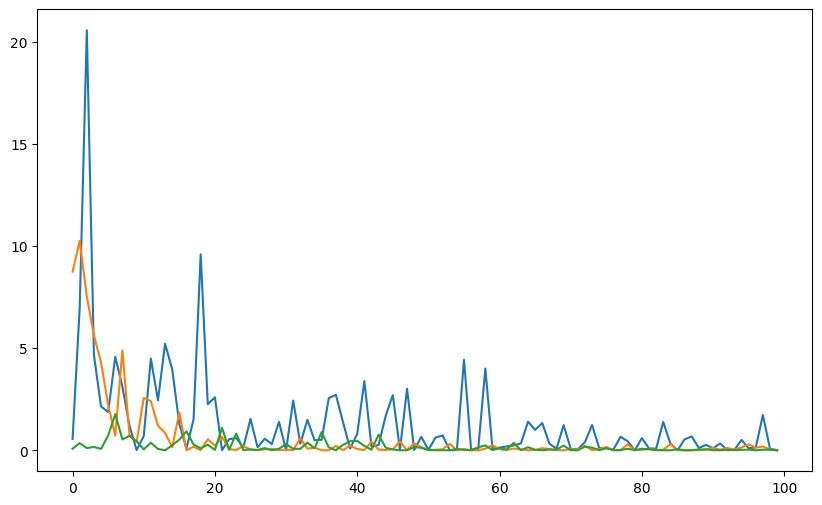

In [ ]:
plt.figure(figsize=(10, 6))
for agent_id, losses in env.performance.items():
    plt.plot(losses[0], label=f'Agent {agent_id}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


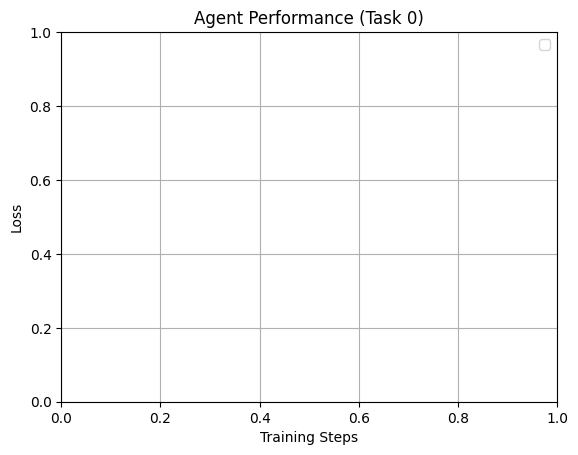

In [ ]:
plt.legend()
plt.title('Agent Performance (Task 0)')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Plot performance for task 1

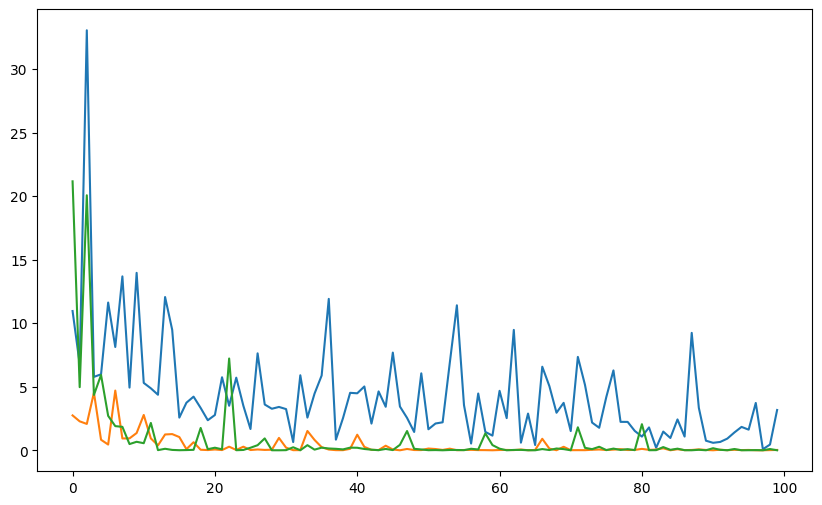

In [ ]:
plt.figure(figsize=(10, 6))
for agent_id, losses in env.performance.items():
    plt.plot(losses[1], label=f'Agent {agent_id}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


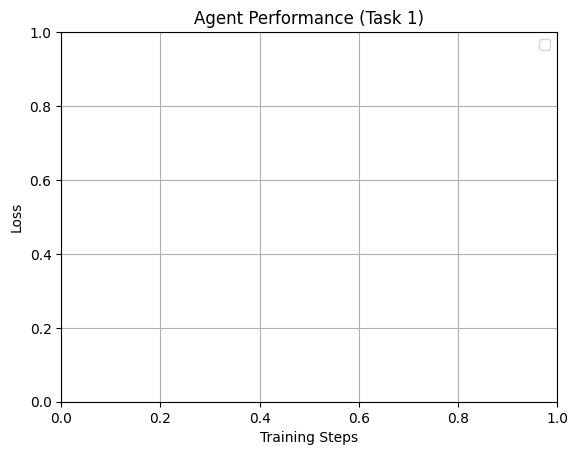

In [ ]:
plt.legend()
plt.title('Agent Performance (Task 1)')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Plot rewards for task 0

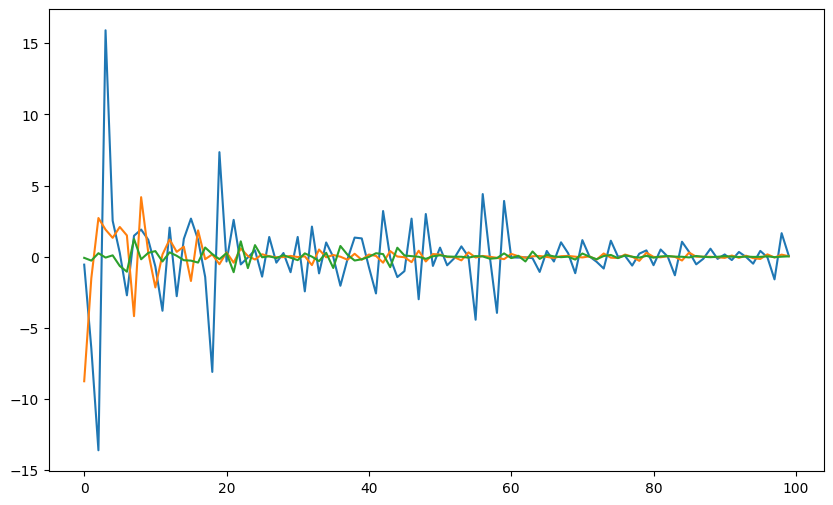

In [ ]:
plt.figure(figsize=(10, 6))
for agent_id, rewards in env.rewards.items():
    plt.plot(rewards[0], label=f'Agent {agent_id}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


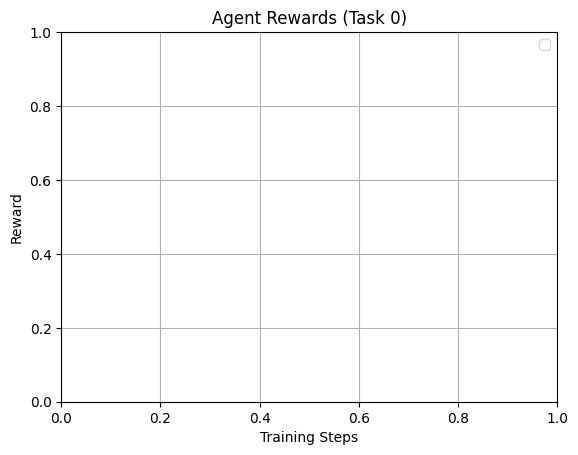

In [ ]:
plt.legend()
plt.title('Agent Rewards (Task 0)')
plt.xlabel('Training Steps')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

Plot rewards for task 1

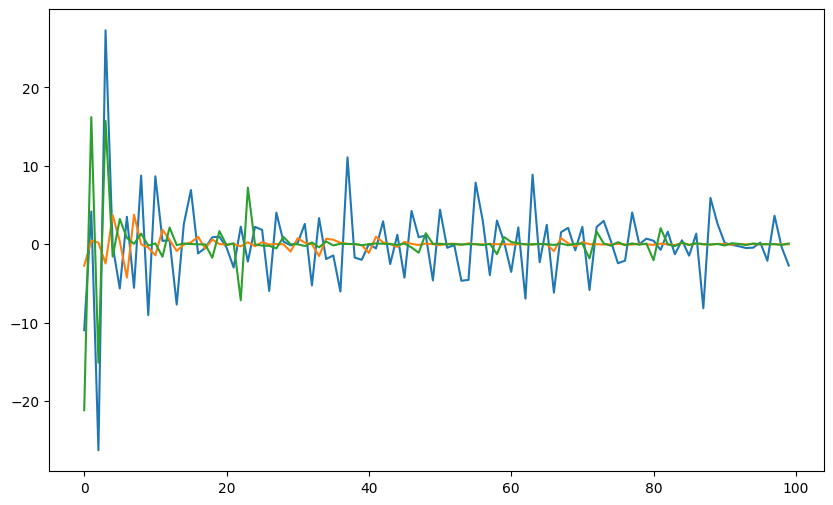

In [ ]:
plt.figure(figsize=(10, 6))
for agent_id, rewards in env.rewards.items():
    plt.plot(rewards[1], label=f'Agent {agent_id}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


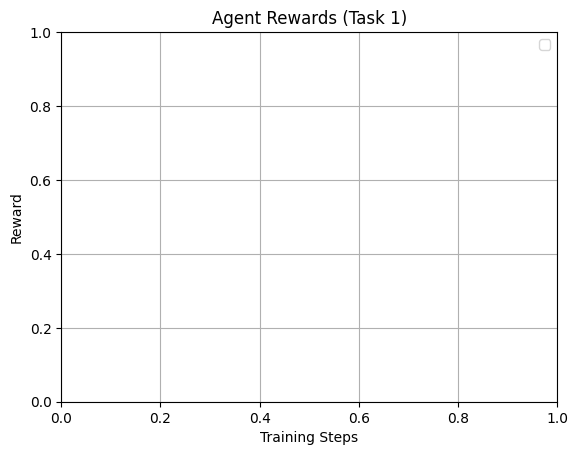

In [ ]:
plt.legend()
plt.title('Agent Rewards (Task 1)')
plt.xlabel('Training Steps')
plt.ylabel('Reward')
plt.grid(True)
plt.show()